In [1]:
#pip installations here
!pip install polars
!pip install --upgrade pip

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/amex-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# initializing variables

In [3]:
# CONSTANTS
MISSINGNESS_THRESHOLD = 0.99
correlation_threshold=0.9
point_biserial_threshold=0.01
stat_sig=0.05

# List of specified categorical columns
categorical_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68','customer_ID','S_2']

# Reading training data and identifying important columns

In [4]:
# Read the CSV 
df_train = pd.read_csv('train_data.csv')
print(df_train.columns)

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=190)


In [5]:
#show all data 
# Ensure all rows are printed
"""pd.set_option('display.max_rows', None)

# Create DataFrame with column names and data types
df_dtypes = pd.DataFrame({"Column Name": df_train.columns, "Data Type": df_train.dtypes})

# Print full DataFrame
print(df_dtypes)

# Reset display option if needed
pd.reset_option('display.max_rows')"""

'pd.set_option(\'display.max_rows\', None)\n\n# Create DataFrame with column names and data types\ndf_dtypes = pd.DataFrame({"Column Name": df_train.columns, "Data Type": df_train.dtypes})\n\n# Print full DataFrame\nprint(df_dtypes)\n\n# Reset display option if needed\npd.reset_option(\'display.max_rows\')'

In [6]:
#identify the unique values of the categorical columns
# Loop through each column and print its unique values
for col in categorical_columns:
    if col in df_train.columns:  # Ensure the column exists in df_train
        print(f"Column: {col}")
        print(df_train[col].unique())  # Print unique values
        print("-" * 50)
    else:
        print(f"Warning: Column '{col}' not found in df_train")

Column: B_30
[ 0.  2.  1. nan]
--------------------------------------------------
Column: B_38
[ 2.  1.  3.  5.  6.  7.  4. nan]
--------------------------------------------------
Column: D_114
[ 1.  0. nan]
--------------------------------------------------
Column: D_116
[ 0. nan  1.]
--------------------------------------------------
Column: D_117


[ 4. -1.  6.  2.  1. nan  3.  5.]
--------------------------------------------------
Column: D_120


[ 0.  1. nan]
--------------------------------------------------
Column: D_126
[ 1. nan  0. -1.]
--------------------------------------------------
Column: D_63


['CR' 'CO' 'CL' 'XZ' 'XM' 'XL']
--------------------------------------------------
Column: D_64
['O' 'R' nan 'U' '-1']
--------------------------------------------------
Column: D_66
[nan  1.  0.]
--------------------------------------------------
Column: D_68
[ 6.  2.  3. nan  5.  4.  0.  1.]
--------------------------------------------------
Column: customer_ID


['0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a'
 '00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5'
 '00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1' ...
 'ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6'
 'ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145b2c3d01967fcce461'
 'fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681']
--------------------------------------------------
Column: S_2


['2017-03-09' '2017-04-07' '2017-05-28' '2017-06-13' '2017-07-16'
 '2017-08-04' '2017-09-18' '2017-10-08' '2017-11-20' '2017-12-04'
 '2018-01-11' '2018-02-21' '2018-03-13' '2017-03-01' '2017-04-16'
 '2017-05-07' '2017-06-25' '2017-07-30' '2017-08-19' '2017-09-15'
 '2017-10-20' '2017-11-24' '2017-12-29' '2018-01-26' '2018-02-06'
 '2018-03-25' '2017-03-11' '2017-04-11' '2017-05-12' '2017-06-10'
 '2017-07-12' '2017-08-12' '2017-09-11' '2017-10-12' '2017-11-11'
 '2017-12-12' '2018-01-12' '2018-02-09' '2018-03-12' '2017-03-31'
 '2017-04-21' '2017-05-29' '2017-06-24' '2017-08-06' '2017-10-23'
 '2017-11-25' '2018-01-18' '2018-02-03' '2018-03-29' '2017-03-30'
 '2017-04-22' '2017-05-30' '2017-06-22' '2017-07-22' '2017-08-07'
 '2017-09-22' '2017-10-29' '2017-11-29' '2017-12-30' '2018-01-30'
 '2018-02-27' '2018-03-30' '2017-03-19' '2017-04-28' '2017-05-19'
 '2017-09-21' '2017-10-26' '2017-11-08' '2018-02-11' '2018-03-19'
 '2017-07-19' '2017-08-09' '2017-09-06' '2017-10-15' '2017-11-10'
 '2017-12-

NOTE:

train_data.csv Data types are mainly in float64 and string 

customerID: string 

S-2(date): string
( we can see that the train statement dates ranges from "2017-12-23" to "2018-03-14" this show )

categorical data colums:
['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
note: D_63,D_64 : string




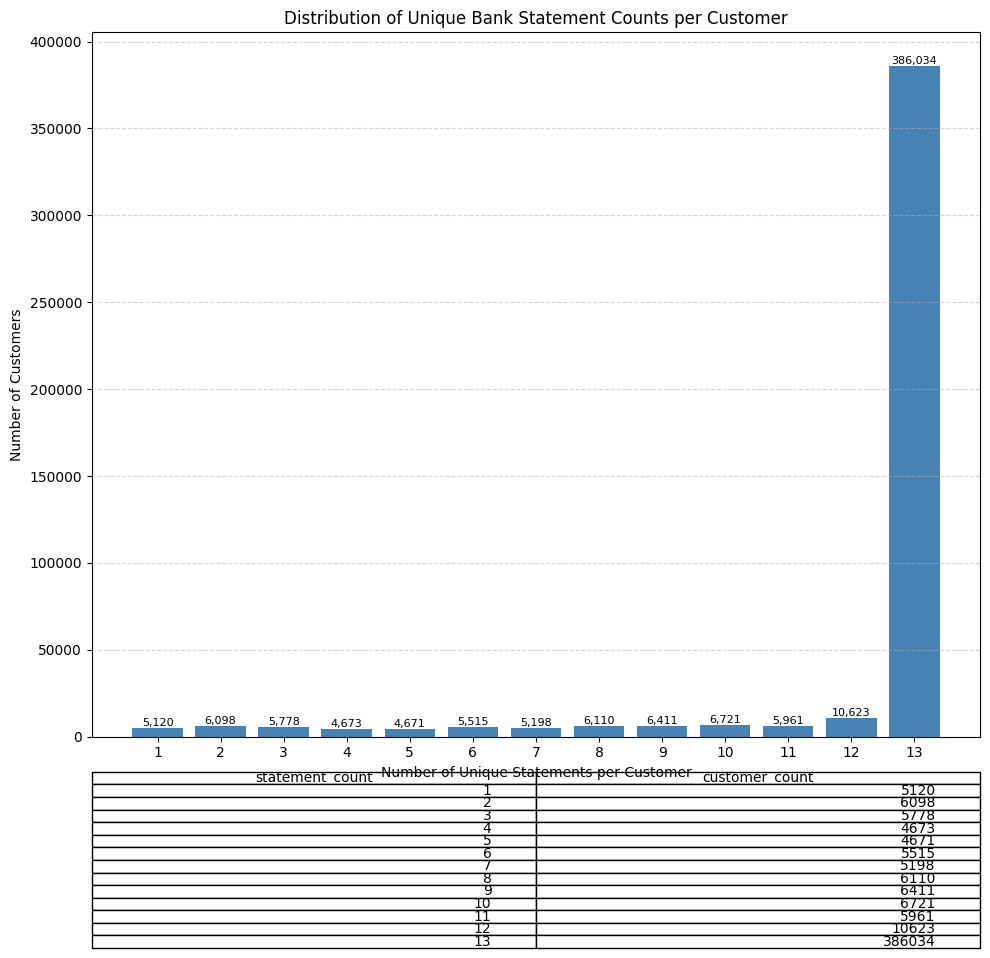

Unique statement counts per customer:
                                              customer_ID  statement_count
458912  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...               13
458873  fffac04d4779c019b73f555e7c969ddd8b05b1cd221271...               13
458875  fffadb0b7f909848854778c7b4b3781430cff772bfcbdf...               13
458877  fffb1641cf36f09a91daf551b8f9d8bfece9fa055b6f60...               13
458878  fffb6886e0bfbb9bb719d153a1e41a780d107fc9190d0e...               13
...                                                   ...              ...
97      000eee12732c9c7b790870c556bc33339d6d17725cbeb4...                1
427008  ee1255eae964507f5b517b26a351ac791c9d3f6a6604e6...                1
169954  5e9f91b29a2c275e9b5d731641b14e14b8ca368fa4fdac...                1
385858  d710a0c1036d13075144261797a3d791abafcb1dde4bd3...                1
385370  d6c959576ef2ff04e9951e5c7823721616cc6829d9ec89...                1

[458913 rows x 2 columns]

Distribution table (statement_coun

In [7]:
# Convert 'S_2' to datetime format
df_train["S_2"] = pd.to_datetime(df_train["S_2"], format="%Y-%m-%d")

# 1. Count UNIQUE statements per customer
unique_counts = (
    df_train.drop_duplicates(subset=["customer_ID", "S_2"])  # Remove duplicate dates per customer
    .groupby("customer_ID")
    .size()
    .reset_index(name="statement_count")
    .sort_values("statement_count", ascending=False)
)


# Count how many customers have each statement count
count_distribution = (
    unique_counts["statement_count"]
    .value_counts()
    .sort_index()  # Ensure the x-axis order (1, 2, 3, ...)
    .rename_axis("statement_count")  # Name the index for clarity
    .reset_index(name="customer_count")
)

# 3. Plot a bar chart of the distribution
plt.figure(figsize=(10, 8))
bars = plt.bar(
    count_distribution["statement_count"].astype(str),  # x-axis labels as strings
    count_distribution["customer_count"],
    color='steelblue'
)

# Annotate each bar with the customer count
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, yval,
        f'{int(yval):,}',  # Format number with comma separators
        va='bottom', ha='center', fontsize=8
    )

plt.xlabel("Number of Unique Statements per Customer")
plt.ylabel("Number of Customers")
plt.title("Distribution of Unique Bank Statement Counts per Customer")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

# 4. Add a table with the distribution data below the chart
plt.table(
    cellText=count_distribution.values,
    colLabels=count_distribution.columns,
    loc="bottom",
    bbox=[0, -0.3, 1, 0.25]
)

plt.show()

# Print raw distribution tables for reference
print("Unique statement counts per customer:")
print(unique_counts)

print("\nDistribution table (statement_count vs. customer_count):")
print(count_distribution)

# Missing values removal functions

In [8]:
#gets the colums with 99% missing data
def missing_columns(data):
    missing_percentages = data.isnull().mean()
    missing_columns = missing_percentages[missing_percentages > MISSINGNESS_THRESHOLD].index
    return missing_columns
    
#removes colums with 99% of data missing ^takes colums from above function
def drop_columns_with_many_missing_values_in_derived_dataset(data,base_columns_to_drop):
  columns_to_drop=[]
  for i in range(0,len(base_columns_to_drop)):
    columns_to_drop.append(base_columns_to_drop[i]+'_')
  columns_to_drop = [col for col in data.columns if (any(word in col for word in columns_to_drop) and ("last" not in col))]
  data_filtered = data.drop(columns=columns_to_drop, errors='ignore')
  return data_filtered

# Handling missing colums

In [9]:
#show the bad cols
list_of_bad_col = missing_columns(df_train)
list_of_bad_col

Index(['D_87', 'D_88', 'D_108', 'D_110', 'D_111', 'B_39'], dtype='object')

In [10]:
# removing the bad colums
print("Before dropping columns with 99% missing values:", df_train.shape)
df_train = drop_columns_with_many_missing_values_in_derived_dataset(df_train,list_of_bad_col)
print("After dropping columns with 99% missing values:", df_train.shape)


Before dropping columns with 99% missing values: (5531451, 190)


After dropping columns with 99% missing values: (5531451, 190)


# aggregating new data

In [11]:
def enhanced_feature_engineering(df_train):
    """
    Performs comprehensive feature engineering on financial data.
    
    Args:
        df: Input DataFrame containing financial features
        
    Returns:
        DataFrame with original and engineered features
    """
    # Data Cleaning
    df_train = df_train.replace([np.inf, -np.inf], np.nan)
    df_train = df_train.fillna(-127)  # Consider using a more meaningful null placeholder
    
    # Feature Identification
    non_feature_cols = ['customer_ID', 'S_2', 'target']
    num_features = [col for col in df_train.columns if col not in non_feature_cols]
    
    
    # Numerical Transformations (now applies to all numerical features)
    num_features = [col for col in num_features if col not in categorical_columns]
    for col in num_features:
        if df_train[col].dtype in ['float64', 'int64']:
            # Skip log transform if negative values exist
            if (df_train[col] >= 0).all():
                df_train[f'{col}_log'] = np.log1p(df_train[col])
    
    # Feature Groupings (now includes all features, not just *_last)
    P_columns = [col for col in num_features if col.startswith('P_')]
    S_columns = [col for col in num_features if col.startswith('S_')]
    B_columns = [col for col in num_features if col.startswith('B_')]
    D_columns = [col for col in num_features if col.startswith('D_')]
    R_columns = [col for col in num_features if col.startswith('R_')]
    
    # 6. Aggregate Features with safer calculations
    df_train['total_payments'] = df_train[P_columns].sum(axis=1)
    df_train['total_spending'] = df_train[S_columns].sum(axis=1)
    df_train['total_balance'] = df_train[B_columns].sum(axis=1)
    df_train['total_delinquency'] = df_train[D_columns].sum(axis=1)
    df_train['total_risk'] = df_train[R_columns].sum(axis=1)
    
    # 7. Ratio Features with zero-division protection
    epsilon = 1e-6
    df_train['risk_to_payment_ratio'] = np.where(
        df_train['total_payments'].abs() > epsilon,
        df_train['total_risk'] / (df_train['total_payments'] + epsilon),
        np.nan
    )
    df_train['delinquency_to_balance_ratio'] = np.where(
        df_train['total_balance'].abs() > epsilon,
        df_train['total_delinquency'] / (df_train['total_balance'] + epsilon),
        np.nan
    )
    
    # 8. Memory Optimization
    for col in df_train.select_dtypes(['float64']).columns:
        if col != "customer_ID":
            df_train[col] = df_train[col].astype(np.float32)
            
    for col in df_train.select_dtypes(['int64']).columns:
        if col != "customer_ID":
            df_train[col] = df_train[col].astype(np.int32)
    
    print(f'Shape after feature engineering: {df_train.shape}')
    print(f'Number of new features created: {len(df_train.columns) - len(non_feature_cols)}')
    
    return df_train

In [12]:
df_train = enhanced_feature_engineering(df_train)

Shape after feature engineering: (5531451, 253)
Number of new features created: 250


# Reducing number of features using correlation

# *handling low correlation data*

In [13]:

from scipy.stats import pointbiserialr

def find_low_point_biserial_correlations_columns(df, target_column, category, suffix):

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(-127, inplace=True)


    columns_to_see = [col for col in df.columns if (col.startswith(category) and col.endswith(suffix)) or col == target_column]
    df = df[columns_to_see]

    correlation_results = []


    for col in columns_to_see:
        if col != target_column:
            correlation, p_value = pointbiserialr(df[target_column], df[col])
            correlation_results.append((col, correlation, p_value))


    correlation_df = pd.DataFrame(correlation_results, columns=['Feature', 'Point-Biserial Correlation', 'p-value'])


    filtered_df = correlation_df[(correlation_df['Point-Biserial Correlation'].abs() < point_biserial_threshold) & (correlation_df['p-value'] < stat_sig)]


    return filtered_df['Feature'].tolist()

In [14]:

category= ["B","P","S","D","R"]
suffix=['first', 'mean', 'std', 'min', 'max']

In [15]:

def remove_low_correlation_columns(df):
    all_cols_to_omit=[]
    for c in category:
        for s in suffix:
            columns_to_omit=find_low_point_biserial_correlations_columns(df,"target",c,s)
            all_cols_to_omit.append(columns_to_omit)
    return all_cols_to_omit

In [16]:

all_low_correlation_columns=remove_low_correlation_columns(df_train)
print("Before dropping low correlation columns:", df_train.shape)
for l in all_low_correlation_columns:
  df_train.drop(columns=l, errors='ignore',inplace=True)
print("After dropping low correlation columns:", df_train.shape)

Before dropping low correlation columns: (5531451, 253)


After dropping low correlation columns: (5531451, 253)


# *handling high correlated data*

In [17]:
from scipy.stats import pearsonr

def find_highly_correlated_columns(df, category, suffix):
    # df=df.to_pandas()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(-127, inplace=True)


    numerical_columns = [col for col in df.columns if col.startswith(category) and col.endswith(suffix)]
    df = df[numerical_columns]


    correlation_matrix = df.corr(method='pearson').abs()


    correlated_pairs = set()
    columns_to_remove = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if correlation_matrix.iloc[i, j] > correlation_threshold:
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]


                correlated_pairs.add((col1, col2))

                columns_to_remove.add(col2)

    return list(columns_to_remove)

def remove_high_correlation_columns(df):
    all_cols_to_omit=[]
    for c in category:
        for s in suffix:
            columns_to_omit=find_highly_correlated_columns(df,c,s)
            all_cols_to_omit.append(columns_to_omit)
    return all_cols_to_omit

In [18]:

all_high_correlation_columns=remove_high_correlation_columns(df_train)
print("Before dropping high correlation columns:", df_train.shape)
for l in all_high_correlation_columns:
  df_train.drop(columns=l, errors='ignore',inplace=True)
print("After dropping high correlation columns:", df_train.shape)

Before dropping high correlation columns: (5531451, 253)


After dropping high correlation columns: (5531451, 253)


test

In [19]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68','customer_ID','S_2']

df_sampled = df_train.sample(n=20000, random_state=42)
df_numeric = df_sampled.drop(cat_features, axis=1)
correlation_matrix = df_numeric.corr()

print(correlation_matrix)
print(type(correlation_matrix))


                                   P_2      D_39       B_1       B_2  \
P_2                           1.000000  0.024467  0.015500  0.216751   
D_39                          0.024467  1.000000  0.189364 -0.018619   
B_1                           0.015500  0.189364  1.000000 -0.089572   
B_2                           0.216751 -0.018619 -0.089572  1.000000   
R_1                           0.014043  0.218970  0.237130 -0.040352   
...                                ...       ...       ...       ...   
total_balance                 0.175413  0.210604  0.328679  0.249785   
total_delinquency             0.461538  0.098952  0.068751  0.152089   
total_risk                    0.024108  0.057337  0.084047 -0.015309   
risk_to_payment_ratio        -0.002322  0.054026 -0.005086 -0.001692   
delinquency_to_balance_ratio -0.223049  0.091569  0.182306 -0.011551   

                                   R_1       S_3      D_41       B_3  \
P_2                           0.014043  0.042498  0.221257  0.2

# Removing Outliers

In [20]:
cat_features2 = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68','customer_ID','S_2']
train_data = df_train
train_data_cat = train_data[cat_features2]
print(train_data_cat.columns.tolist())



['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68', 'customer_ID', 'S_2']


In [21]:
print(train_data.columns.tolist())

missing_cols = [col for col in cat_features if col not in train_data.columns]
print("Missing columns:", missing_cols)


['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'D_49', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_63', 'D_64', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'D_66', 'B_20', 'D_68', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'D_73', 'P_4', 'D_74', 'D_75', 'D_76', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'R_9', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'D_82', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'B_29', 'B_30', 'S_18', 'D_86', 'D_87', 'R_17', 'R_18', 'D_88', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_2

In [22]:
train_data_num = train_data.drop(cat_features, axis=1, errors='ignore')


In [23]:
for col in train_data_num.columns:
    if col not in cat_features:
        Q1 = train_data_num[col].quantile(0.25)
        Q3 = train_data_num[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        train_data_num = train_data_num[
            (train_data_num[col] >= lower_bound) & (train_data_num[col] <= upper_bound)
        ]

print(train_data_num)


              P_2      D_39       B_1       B_2       R_1    S_3      D_41  \
29       0.852514  0.006877  0.007627  0.819987  0.009290 -127.0  0.003959   
30       0.891656  0.000802  0.009997  0.811041  0.003540 -127.0  0.009034   
31       0.902419  0.005366  0.003352  0.811922  0.004008 -127.0  0.008727   
32       0.904482  0.005470  0.006262  0.818312  0.005699 -127.0  0.009560   
33       0.903964  0.000832  0.001506  0.813006  0.009443 -127.0  0.001653   
...           ...       ...       ...       ...       ...    ...       ...   
5527643  1.005729  0.001083  0.006314  0.816413  0.001071 -127.0  0.008245   
5530801  0.886600  0.009523  0.004355  0.817521  0.009703 -127.0  0.005514   
5530802  0.889943  0.006933  0.007706  0.816375  0.005654 -127.0  0.005028   
5531122  0.748220  0.002450  0.005508  0.813587  0.003644 -127.0  0.005267   
5531123  0.755100  0.002304  0.005679  0.814807  0.003110 -127.0  0.008136   

              B_3   D_42        D_43  ...  B_36_log  D_127_log 

In [24]:
# 4. Standardize the numerical columns (mean=0, std=1)
train_data_num = (train_data_num - train_data_num.mean()) / train_data_num.std()

In [25]:
train_data_num

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,B_36_log,D_127_log,R_28_log,total_payments,total_spending,total_balance,total_delinquency,total_risk,risk_to_payment_ratio,delinquency_to_balance_ratio
29,-0.750931,0.667367,0.838917,0.652541,1.500292,NaN,-0.362634,0.877097,NaN,-0.742918,...,-1.003923,-1.595936,0.005048,-0.770553,2.101806,-0.006974,-1.391233,-1.290143,-0.736494,1.391336
30,-0.145450,-1.438703,1.658467,-0.577356,-0.500886,NaN,1.402156,-1.515777,NaN,-0.742918,...,-0.642159,-0.603772,1.669442,0.308187,0.775041,1.661773,-1.391900,1.792103,0.357982,1.395949
31,0.021051,0.143657,-0.639534,-0.456240,-0.337774,NaN,1.295252,0.439772,NaN,-0.742918,...,0.506139,1.372672,-1.011962,0.337598,0.827586,-0.461568,-0.309682,-0.766824,0.383457,0.308667
32,0.052966,0.179587,0.367019,0.422372,0.250556,NaN,1.584807,1.407488,NaN,-0.742918,...,-1.079576,-0.041028,-1.697074,0.446147,0.267980,0.750049,-0.310237,-1.231403,0.485041,0.311963
33,0.044958,-1.428205,-1.277757,-0.307165,1.553424,NaN,-1.164322,1.518570,NaN,-0.742918,...,-0.091639,1.162662,-1.143250,0.303315,-2.317241,-0.642265,-0.310999,-0.690996,0.351043,0.309576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5527643,1.619172,-1.341113,0.384969,0.161171,-1.360004,NaN,1.127587,1.005146,NaN,1.347029,...,1.632760,0.949834,0.564743,2.134767,-0.044663,1.432257,0.810562,1.023143,1.925030,-0.807541
5530801,-0.223653,1.584728,-0.292435,0.313508,1.643915,NaN,0.177900,-1.152885,NaN,-0.742918,...,-1.342138,1.631807,0.919260,-0.153439,0.599015,-2.110661,-0.298429,-0.834108,-0.094492,0.293689
5530802,-0.171945,0.686707,0.866248,0.155967,0.234943,NaN,0.009011,1.609397,NaN,-0.742918,...,1.537276,1.507337,-0.988580,-0.229680,0.496552,1.221761,-0.299104,0.795660,-0.169629,0.301892
5531122,-2.364279,-0.867393,0.106166,-0.227243,-0.464733,NaN,0.092075,1.295100,NaN,-0.742918,...,0.586984,-1.395551,1.410415,-1.841879,1.460755,0.910456,-1.366894,0.430404,-1.972359,1.369161


In [26]:
# 5. Concatenate the numerical and categorical data
train_data = pd.concat([train_data_cat, train_data_num], axis=1)

In [27]:
train_data.head()

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_66,...,B_36_log,D_127_log,R_28_log,total_payments,total_spending,total_balance,total_delinquency,total_risk,risk_to_payment_ratio,delinquency_to_balance_ratio
0,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,-127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,-127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,-127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,-127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,-127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Handling Categorical Variables 

In [28]:
# train_data_cat.null_count()
# print(500/len(train_data))

In [29]:
train_data = train_data.dropna()

In [30]:
train_data['target'].value_counts()

KeyError: 'target'

In [31]:
train_data_cp = train_data

In [32]:
df_majority = df_train[df_train['target'] == 0]
df_minority = df_train[df_train['target'] == 1]

# Determine the number of samples for upsampling
n_samples = len(df_majority)

# Upsample minority class
df_minority_upsampled = df_minority.sample(
    n=n_samples, 
    replace=True,  # Replace to allow upsampling
    random_state=42  # Set the seed for reproducibility
)
# Combine majority and upsampled minority classes
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

print(df_upsampled)


KeyError: 'target'

In [33]:
train_data = df_upsampled

NameError: name 'df_upsampled' is not defined

In [34]:
train_data['target'].value_counts()

KeyError: 'target'

In [35]:
train_data_cat_encoded = pd.get_dummies(train_data_cat)
print(train_data_cat_encoded)

MemoryError: Unable to allocate 2.31 TiB for an array with shape (5531451, 458913) and data type bool